# 🔬 Deteksi Wajah dan Diagnosis Penyakit Kulit Wajah
## Menggunakan Deep Learning (CNN)

Notebook ini mengimplementasikan sistem dua tahap:
1. **Face Detection**: Menggunakan MTCNN untuk mendeteksi dan crop area wajah
2. **Skin Disease Classification**: Menggunakan CNN dengan Transfer Learning (MobileNetV2) untuk klasifikasi penyakit kulit

---

## 📦 1. Setup dan Instalasi Library

Instalasi semua library yang diperlukan untuk proyek ini.

In [1]:
# Instalasi library yang diperlukan
!pip install mtcnn
!pip install tensorflow
!pip install opencv-python
!pip install pillow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import library
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import Counter

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Conv2D, 
    MaxPooling2D, Flatten, BatchNormalization, Activation
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# MTCNN untuk face detection
from mtcnn import MTCNN

# Scikit-learn untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU Available: []


In [3]:
# Set random seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Konfigurasi plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 💾 2. Konfigurasi Path dan Parameter

Definisikan path dataset dan hyperparameter model.

In [4]:
# ========================================
# KONFIGURASI PATH DATASET
# ========================================
# Untuk Google Colab: mount Google Drive terlebih dahulu
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = '/content/drive/MyDrive/skin_disease_dataset'

# Untuk lokal/Jupyter:
DATASET_PATH = './Face_Detection_Skin_Disease_Dataset'  # Sesuaikan dengan path dataset Anda

# Struktur folder dataset yang diharapkan:
# skin_disease_dataset/
#   ├── acne/
#   │   ├── img1.jpg
#   │   ├── img2.jpg
#   ├── eczema/
#   ├── melasma/
#   ├── healthy/
#   └── ...

# Path untuk menyimpan model dan hasil
OUTPUT_DIR = './output'
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'skin_disease_model.h5')
FACES_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'detected_faces')

# Buat direktori jika belum ada
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FACES_OUTPUT_DIR, exist_ok=True)

In [5]:
# ========================================
# HYPERPARAMETER
# ========================================
IMG_SIZE = (224, 224)  # Input size untuk MobileNetV2
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# Parameter face detection
MIN_FACE_SIZE = 20  # Minimum ukuran wajah yang dideteksi
CONFIDENCE_THRESHOLD = 0.9  # Threshold confidence untuk MTCNN

print("✅ Konfigurasi berhasil dimuat")

✅ Konfigurasi berhasil dimuat


## 🎭 3. Face Detection - Tahap Pertama

Implementasi MTCNN untuk mendeteksi dan mengekstrak area wajah dari gambar.

In [8]:
# Inisialisasi MTCNN detector
face_detector = MTCNN()

def detect_and_crop_face(image_path, output_path=None, margin=20):
    """
    Deteksi wajah dari gambar dan crop area wajah.
    
    Args:
        image_path: Path ke gambar input
        output_path: Path untuk menyimpan hasil crop (optional)
        margin: Pixel tambahan di sekitar wajah
    
    Returns:
        cropped_face: Array numpy dari wajah yang di-crop
        detection: Dictionary informasi deteksi wajah
    """
    try:
        # Baca gambar
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Gagal membaca gambar: {image_path}")
            return None, None
        
        # Convert BGR to RGB (MTCNN menggunakan RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Deteksi wajah
        detections = face_detector.detect_faces(img_rgb)
        
        if len(detections) == 0:
            print(f"⚠️ Tidak ada wajah terdeteksi: {image_path}")
            return None, None
        
        # Ambil deteksi dengan confidence tertinggi
        detection = max(detections, key=lambda x: x['confidence'])
        
        if detection['confidence'] < CONFIDENCE_THRESHOLD:
            print(f"⚠️ Confidence rendah ({detection['confidence']:.2f}): {image_path}")
            return None, None
        
        # Ekstrak bounding box
        x, y, width, height = detection['box']
        
        # Tambahkan margin dan pastikan tidak keluar dari boundaries
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(img_rgb.shape[1], x + width + margin)
        y2 = min(img_rgb.shape[0], y + height + margin)
        
        # Crop wajah
        cropped_face = img_rgb[y1:y2, x1:x2]
        
        # Simpan jika path disediakan
        if output_path:
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))
        
        return cropped_face, detection
    
    except Exception as e:
        print(f"❌ Error saat memproses {image_path}: {str(e)}")
        return None, None

def visualize_face_detection(image_path):
    """
    Visualisasi hasil deteksi wajah.
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    detections = face_detector.detect_faces(img_rgb)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image dengan bounding box
    img_with_box = img_rgb.copy()
    for detection in detections:
        x, y, width, height = detection['box']
        confidence = detection['confidence']
        cv2.rectangle(img_with_box, (x, y), (x+width, y+height), (255, 0, 0), 2)
        cv2.putText(img_with_box, f'{confidence:.2f}', (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    axes[0].imshow(img_with_box)
    axes[0].set_title('Deteksi Wajah dengan Bounding Box')
    axes[0].axis('off')
    
    # Cropped face
    cropped_face, _ = detect_and_crop_face(image_path)
    if cropped_face is not None:
        axes[1].imshow(cropped_face)
        axes[1].set_title('Wajah yang Di-crop')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'Wajah tidak terdeteksi', 
                     ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Fungsi face detection berhasil didefinisikan")

✅ Fungsi face detection berhasil didefinisikan


### Test Face Detection

Uji coba deteksi wajah pada sample gambar.

In [9]:
# Test face detection dengan sample gambar
# Uncomment dan sesuaikan path jika ingin test

# sample_image = './sample_face.jpg'
# if os.path.exists(sample_image):
#     print("🔍 Testing face detection...")
#     visualize_face_detection(sample_image)
# else:
#     print("⚠️ Sample image tidak ditemukan. Upload gambar untuk test.")

## 📊 4. Data Loading dan Preprocessing

Load dataset, ekstrak wajah, dan preprocessing untuk training.

In [10]:
def load_dataset_with_face_detection(dataset_path, save_faces=True):
    """
    Load dataset, deteksi wajah, dan prepare untuk training.
    
    Args:
        dataset_path: Path ke root folder dataset
        save_faces: Jika True, simpan wajah yang terdeteksi
    
    Returns:
        faces: List array numpy dari wajah
        labels: List label penyakit kulit
        class_names: List nama kelas
    """
    faces = []
    labels = []
    class_names = []
    
    # Validasi path dataset
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset path tidak ditemukan: {dataset_path}")
        print("\n📝 Cara membuat dataset dummy untuk testing:")
        print("   Buat folder dengan struktur:")
        print("   skin_disease_dataset/")
        print("     ├── acne/")
        print("     ├── eczema/")
        print("     ├── melasma/")
        print("     └── healthy/")
        return None, None, None
    
    # Dapatkan semua kelas (subfolder)
    class_folders = [f for f in os.listdir(dataset_path) 
                     if os.path.isdir(os.path.join(dataset_path, f))]
    class_folders.sort()
    
    if len(class_folders) == 0:
        print("❌ Tidak ada folder kelas ditemukan dalam dataset")
        return None, None, None
    
    print(f"📂 Ditemukan {len(class_folders)} kelas: {class_folders}")
    print("\n🔍 Memproses dataset...")
    
    stats = {
        'total_images': 0,
        'successful_detections': 0,
        'failed_detections': 0
    }
    
    for class_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_name)
        class_names.append(class_name)
        
        # Dapatkan semua gambar dalam folder kelas
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"\n  📁 {class_name}: {len(image_files)} gambar")
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            stats['total_images'] += 1
            
            # Deteksi dan crop wajah
            output_path = None
            if save_faces:
                output_path = os.path.join(FACES_OUTPUT_DIR, class_name, img_file)
            
            face, detection = detect_and_crop_face(img_path, output_path)
            
            if face is not None:
                faces.append(face)
                labels.append(class_idx)
                stats['successful_detections'] += 1
            else:
                stats['failed_detections'] += 1
        
        print(f"     ✅ Berhasil: {len([l for l in labels if l == class_idx])} wajah")
    
    print("\n" + "="*50)
    print("📊 STATISTIK DATASET:")
    print(f"  Total gambar: {stats['total_images']}")
    print(f"  Deteksi berhasil: {stats['successful_detections']}")
    print(f"  Deteksi gagal: {stats['failed_detections']}")
    print(f"  Success rate: {stats['successful_detections']/stats['total_images']*100:.2f}%")
    print("="*50)
    
    return faces, labels, class_names

print("✅ Fungsi load dataset berhasil didefinisikan")

✅ Fungsi load dataset berhasil didefinisikan


In [12]:
# Load dataset
print("🚀 Memulai proses loading dataset...\n")
faces, labels, class_names = load_dataset_with_face_detection(
    DATASET_PATH, 
    save_faces=True
)

# Validasi hasil loading
if faces is None or len(faces) == 0:
    print("\n❌ Dataset gagal dimuat atau kosong.")
    print("\n💡 SOLUSI:")
    print("1. Pastikan path dataset benar")
    print("2. Pastikan struktur folder sesuai")
    print("3. Pastikan gambar mengandung wajah yang jelas")
    print("\n📝 Untuk testing, Anda bisa membuat dataset dummy atau gunakan dataset publik seperti:")
    print("   - Dermnet (https://dermnet.com/)")
    print("   - HAM10000 dataset")
    print("   - ISIC Archive")
else:
    print(f"\n✅ Dataset berhasil dimuat!")
    print(f"   Total samples: {len(faces)}")
    print(f"   Jumlah kelas: {len(class_names)}")
    print(f"   Kelas: {class_names}")

🚀 Memulai proses loading dataset...

📂 Ditemukan 3 kelas: ['acne', 'bags', 'redness']

🔍 Memproses dataset...

  📁 acne: 10 gambar
     ✅ Berhasil: 10 wajah

  📁 bags: 10 gambar
     ✅ Berhasil: 10 wajah

  📁 redness: 10 gambar
     ✅ Berhasil: 10 wajah

📊 STATISTIK DATASET:
  Total gambar: 30
  Deteksi berhasil: 30
  Deteksi gagal: 0
  Success rate: 100.00%

✅ Dataset berhasil dimuat!
   Total samples: 30
   Jumlah kelas: 3
   Kelas: ['acne', 'bags', 'redness']


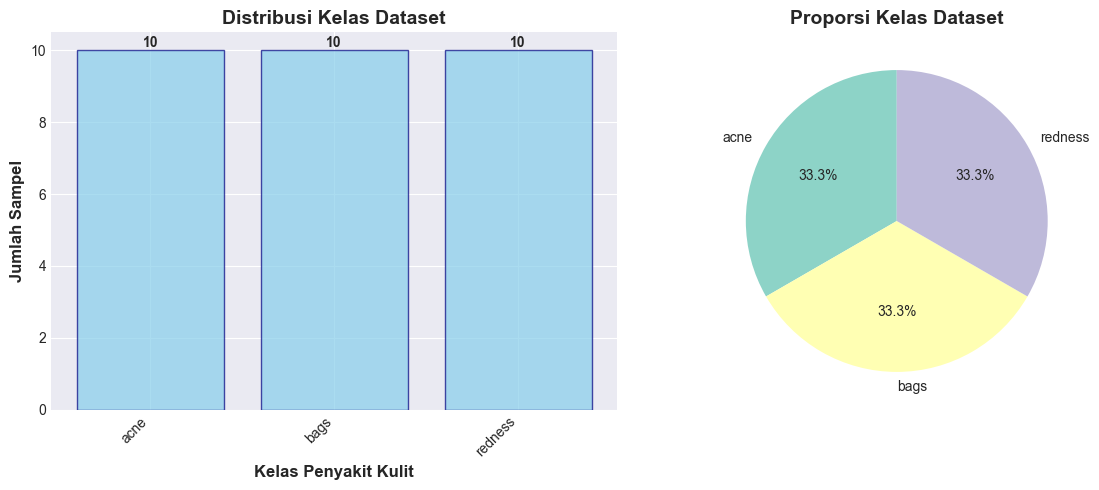

In [13]:
# Visualisasi distribusi kelas
if faces is not None and len(faces) > 0:
    label_counts = Counter(labels)
    
    plt.figure(figsize=(12, 5))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    counts = [label_counts[i] for i in range(len(class_names))]
    bars = plt.bar(class_names, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Kelas Penyakit Kulit', fontsize=12, fontweight='bold')
    plt.ylabel('Jumlah Sampel', fontsize=12, fontweight='bold')
    plt.title('Distribusi Kelas Dataset', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Tambahkan label nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Set3.colors)
    plt.title('Proporsi Kelas Dataset', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

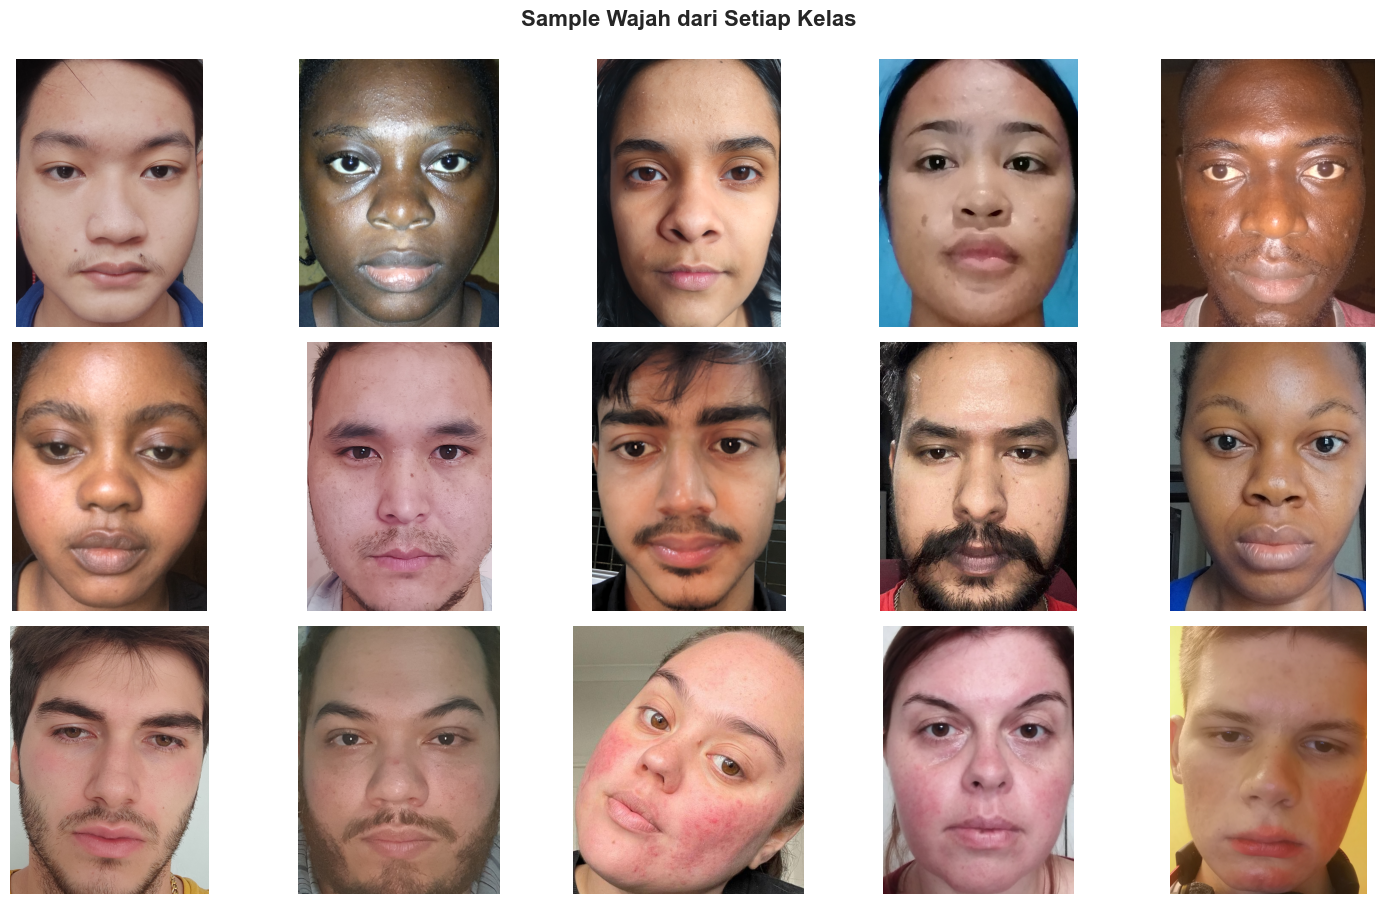

In [14]:
# Visualisasi sample wajah dari setiap kelas
if faces is not None and len(faces) > 0:
    n_classes = len(class_names)
    n_samples = min(5, min([Counter(labels)[i] for i in range(n_classes)]))
    
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(15, n_classes * 3))
    
    for class_idx, class_name in enumerate(class_names):
        # Dapatkan indices untuk kelas ini
        class_indices = [i for i, label in enumerate(labels) if label == class_idx]
        
        # Pilih random samples
        sample_indices = random.sample(class_indices, min(n_samples, len(class_indices)))
        
        for sample_idx, face_idx in enumerate(sample_indices):
            if n_classes > 1:
                ax = axes[class_idx, sample_idx]
            else:
                ax = axes[sample_idx]
            
            ax.imshow(faces[face_idx])
            ax.axis('off')
            
            if sample_idx == 0:
                ax.set_ylabel(class_name, fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Wajah dari Setiap Kelas', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

### Preprocessing dan Split Dataset

In [15]:
def preprocess_faces(faces, labels, img_size=IMG_SIZE):
    """
    Preprocessing wajah untuk training:
    - Resize ke ukuran yang seragam
    - Normalisasi pixel values [0, 1]
    """
    processed_faces = []
    
    print("🔄 Preprocessing wajah...")
    for face in faces:
        # Resize
        resized = cv2.resize(face, img_size)
        # Normalisasi ke [0, 1]
        normalized = resized.astype('float32') / 255.0
        processed_faces.append(normalized)
    
    # Convert ke numpy array
    X = np.array(processed_faces)
    y = np.array(labels)
    
    print(f"✅ Preprocessing selesai")
    print(f"   Shape X: {X.shape}")
    print(f"   Shape y: {y.shape}")
    print(f"   Range nilai X: [{X.min():.3f}, {X.max():.3f}]")
    
    return X, y

In [16]:
# Preprocess faces
if faces is not None and len(faces) > 0:
    X, y = preprocess_faces(faces, labels)
    
    # Split dataset: train, validation, test
    # Pertama split train dan temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(VALIDATION_SPLIT + TEST_SPLIT),
        random_state=SEED,
        stratify=y
    )
    
    # Split temp menjadi validation dan test
    val_test_ratio = TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_test_ratio,
        random_state=SEED,
        stratify=y_temp
    )
    
    print("\n📊 SPLIT DATASET:")
    print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"  Total: {len(X)} samples")
    
    # Konversi label ke categorical (one-hot encoding)
    num_classes = len(class_names)
    y_train_cat = keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes)
    
    print(f"\n✅ Data siap untuk training!")
else:
    print("❌ Tidak dapat melanjutkan tanpa dataset yang valid")

🔄 Preprocessing wajah...
✅ Preprocessing selesai
   Shape X: (30, 224, 224, 3)
   Shape y: (30,)
   Range nilai X: [0.000, 1.000]

📊 SPLIT DATASET:
  Training set: 20 samples (66.7%)
  Validation set: 6 samples (20.0%)
  Test set: 4 samples (13.3%)
  Total: 30 samples

✅ Data siap untuk training!


## 🏗️ 5. Model Building - CNN dengan Transfer Learning

Membangun model menggunakan MobileNetV2 sebagai feature extractor dengan custom classifier.

In [17]:
def build_model(num_classes, img_size=IMG_SIZE, learning_rate=LEARNING_RATE):
    """
    Membangun model CNN dengan Transfer Learning (MobileNetV2).
    
    Args:
        num_classes: Jumlah kelas output
        img_size: Ukuran input gambar
        learning_rate: Learning rate untuk optimizer
    
    Returns:
        model: Model Keras yang sudah di-compile
    """
    print("🏗️ Membangun model...")
    
    # Load MobileNetV2 pre-trained pada ImageNet
    base_model = MobileNetV2(
        input_shape=(*img_size, 3),
        include_top=False,  # Tidak termasuk fully connected layer
        weights='imagenet'
    )
    
    # Freeze base model layers untuk transfer learning
    base_model.trainable = False
    
    # Bangun model lengkap
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ], name='SkinDiseaseClassifier')
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    print("✅ Model berhasil dibangun\n")
    
    return model

def build_custom_cnn(num_classes, img_size=IMG_SIZE, learning_rate=LEARNING_RATE):
    """
    Alternative: Build custom CNN dari scratch (tanpa transfer learning).
    """
    print("🏗️ Membangun custom CNN...")
    
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding='same', input_shape=(*img_size, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ], name='CustomCNN')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    print("✅ Custom CNN berhasil dibangun\n")
    
    return model

In [18]:
# Build model
if faces is not None and len(faces) > 0:
    # Pilih salah satu: Transfer Learning atau Custom CNN
    USE_TRANSFER_LEARNING = True  # Set False untuk menggunakan custom CNN
    
    if USE_TRANSFER_LEARNING:
        model = build_model(num_classes=len(class_names))
    else:
        model = build_custom_cnn(num_classes=len(class_names))
    
    # Display model summary
    model.summary()

🏗️ Membangun model...
✅ Model berhasil dibangun



Model: "SkinDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,086,659 (11.77 MB)

 Trainable params: 824,579 (3.15 MB)

 Non-trainable params: 2,262,080 (8.63 MB)

In [19]:
# Visualisasi arsitektur model
if faces is not None and len(faces) > 0:
    try:
        keras.utils.plot_model(
            model, 
            to_file=os.path.join(OUTPUT_DIR, 'model_architecture.png'),
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=False,
            dpi=96
        )
        print("✅ Diagram arsitektur model disimpan di: output/model_architecture.png")
    except Exception as e:
        print(f"⚠️ Tidak dapat membuat visualisasi model: {e}")

You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Diagram arsitektur model disimpan di: output/model_architecture.png


## 🎯 6. Training Model

Melatih model dengan callbacks untuk early stopping dan learning rate reduction.

In [20]:
# Data Augmentation untuk meningkatkan generalisasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

print("✅ Data augmentation dikonfigurasi")

✅ Data augmentation dikonfigurasi


In [21]:
# Setup callbacks
callbacks = [
    # Early stopping: stop training jika tidak ada improvement
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate jika plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✅ Callbacks dikonfigurasi")

✅ Callbacks dikonfigurasi


In [22]:
# Training model
if faces is not None and len(faces) > 0:
    print("\n" + "="*60)
    print("🚀 MEMULAI TRAINING MODEL")
    print("="*60)
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print("="*60 + "\n")
    
    # Training dengan data augmentation
    history = model.fit(
        datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val_cat),
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n" + "="*60)
    print("✅ TRAINING SELESAI!")
    print("="*60)


🚀 MEMULAI TRAINING MODEL
Epochs: 50
Batch size: 32
Learning rate: 0.0001
Training samples: 20
Validation samples: 6

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3000 - loss: 2.0900 - precision: 0.2778 - recall: 0.2500
Epoch 1: val_accuracy improved from None to 0.16667, saving model to ./output\skin_disease_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3000 - loss: 2.0900 - precision: 0.2778 - recall: 0.2500 - val_accuracy: 0.1667 - val_loss: 1.2301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5500 - loss: 1.3010 - precision: 0.5556 - recall: 0.5000
Epoch 2: val_accuracy did not improve from 0.16667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.5500 - loss: 1.3010 - precision: 0.5556 - recall: 0.5000 - val_accuracy: 0.1667 - val_loss: 1.2295 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.2500 - loss: 1.4333 - precision: 0.2143 - recall: 0.1500
Epoch 3: val_accuracy did not improve from 0.16667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 0.2500 - loss: 1.4333 - precision: 0.2143 - recall: 0.1500 - val_accuracy: 0.1667 - val_loss: 1.2315 - val_precision: 0.0000e+00 - val_recal

### Visualisasi Training History

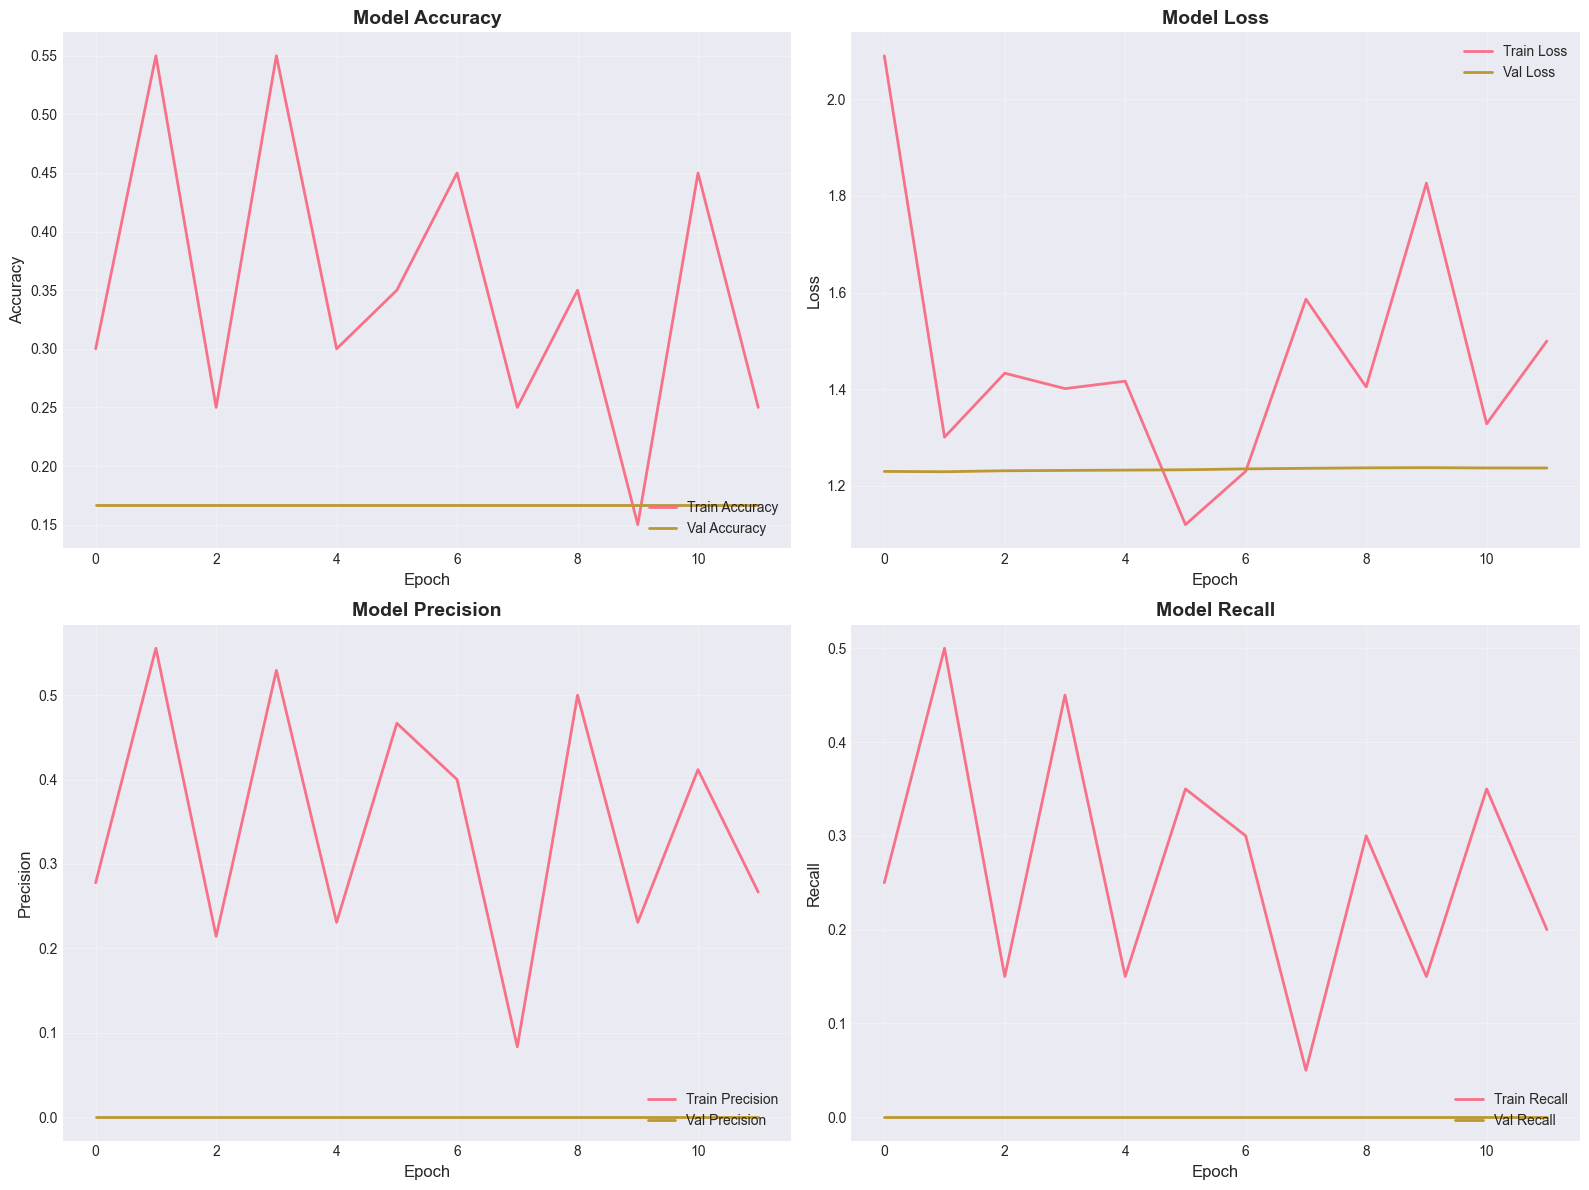

✅ Training history plot disimpan di: output/training_history.png


In [23]:
# Plot training history
if faces is not None and len(faces) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Recall', fontsize=12)
    axes[1, 1].legend(loc='lower right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Training history plot disimpan di: output/training_history.png")

## 📈 7. Model Evaluation

Evaluasi performa model pada test set.

In [24]:
# Evaluasi pada test set
if faces is not None and len(faces) > 0:
    print("\n🔍 EVALUASI MODEL PADA TEST SET")
    print("="*60)
    
    # Prediksi
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Hitung metrik
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
        X_test, y_test_cat, verbose=0
    )
    
    # F1 Score
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    print(f"\n📊 METRIK EVALUASI:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall: {test_recall:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    print("="*60)


🔍 EVALUASI MODEL PADA TEST SET

📊 METRIK EVALUASI:
  Test Loss: 1.0765
  Test Accuracy: 0.5000 (50.00%)
  Test Precision: 0.0000
  Test Recall: 0.0000
  Test F1-Score: 0.4583


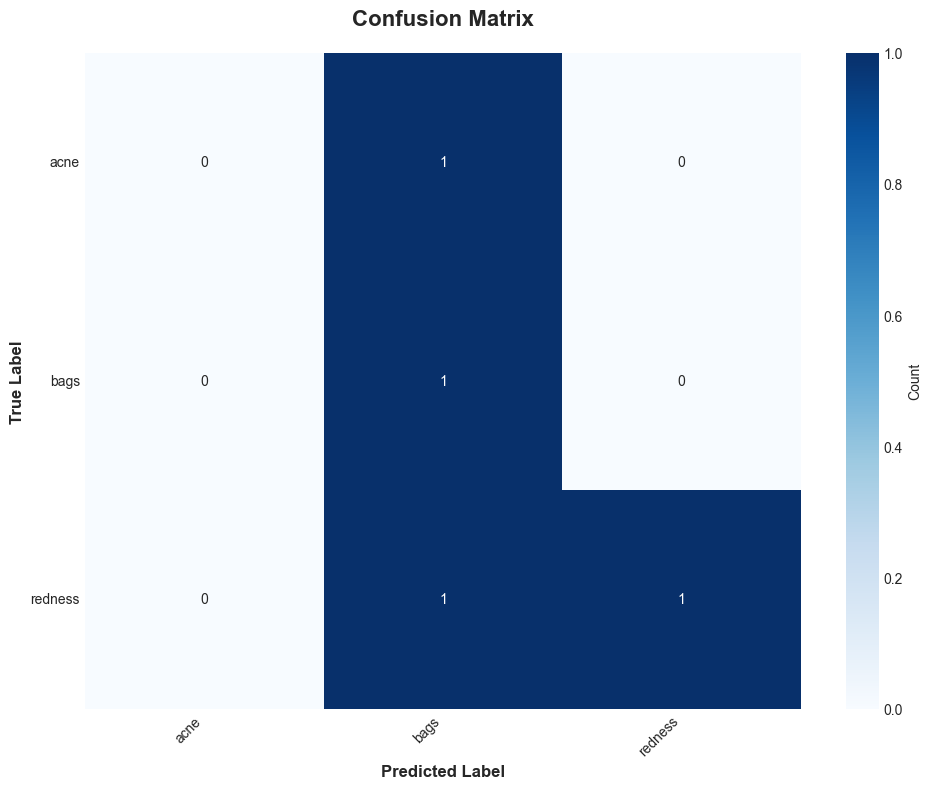

✅ Confusion matrix disimpan di: output/confusion_matrix.png


In [25]:
# Confusion Matrix
if faces is not None and len(faces) > 0:
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Confusion matrix disimpan di: output/confusion_matrix.png")

In [26]:
# Classification Report
if faces is not None and len(faces) > 0:
    print("\n📋 CLASSIFICATION REPORT:")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print("="*60)


📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        acne     0.0000    0.0000    0.0000         1
        bags     0.3333    1.0000    0.5000         1
     redness     1.0000    0.5000    0.6667         2

    accuracy                         0.5000         4
   macro avg     0.4444    0.5000    0.3889         4
weighted avg     0.5833    0.5000    0.4583         4



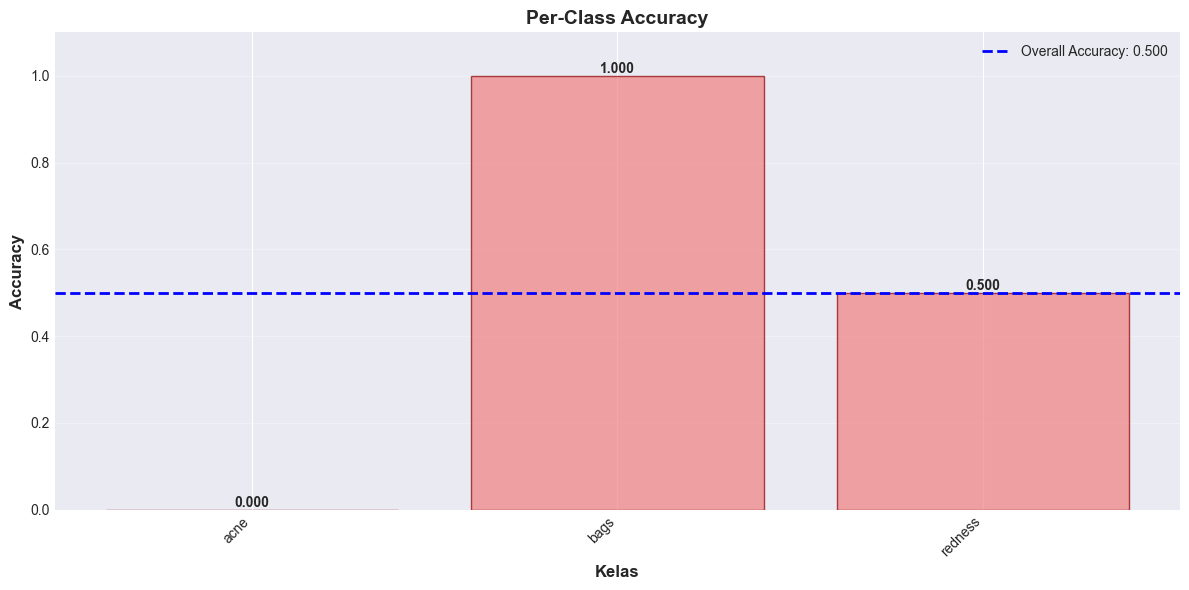

✅ Per-class accuracy plot disimpan di: output/per_class_accuracy.png


In [27]:
# Per-class accuracy visualization
if faces is not None and len(faces) > 0:
    # Hitung accuracy per kelas
    per_class_accuracy = []
    for i in range(len(class_names)):
        mask = y_test == i
        if mask.sum() > 0:
            acc = (y_pred[mask] == y_test[mask]).sum() / mask.sum()
            per_class_accuracy.append(acc)
        else:
            per_class_accuracy.append(0)
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, per_class_accuracy, color='lightcoral', edgecolor='darkred', alpha=0.7)
    plt.axhline(y=test_accuracy, color='blue', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_accuracy:.3f}')
    plt.xlabel('Kelas', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim([0, 1.1])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Tambahkan label nilai
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'per_class_accuracy.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Per-class accuracy plot disimpan di: output/per_class_accuracy.png")

## 🔮 8. Prediction Pipeline

Fungsi untuk melakukan prediksi end-to-end: deteksi wajah → klasifikasi penyakit.

In [28]:
def predict_skin_disease(image_path, model, class_names, visualize=True):
    """
    Pipeline lengkap untuk prediksi penyakit kulit:
    1. Deteksi wajah
    2. Preprocessing
    3. Klasifikasi
    4. Visualisasi hasil
    
    Args:
        image_path: Path ke gambar input
        model: Model Keras untuk klasifikasi
        class_names: List nama kelas
        visualize: Jika True, tampilkan visualisasi hasil
    
    Returns:
        result: Dictionary berisi hasil prediksi
    """
    result = {
        'success': False,
        'image_path': image_path,
        'face_detected': False,
        'predicted_class': None,
        'confidence': None,
        'all_probabilities': None
    }
    
    # 1. Deteksi wajah
    face, detection = detect_and_crop_face(image_path)
    
    if face is None:
        print(f"❌ Tidak dapat mendeteksi wajah pada gambar: {image_path}")
        return result
    
    result['face_detected'] = True
    result['detection_confidence'] = detection['confidence']
    
    # 2. Preprocessing
    face_resized = cv2.resize(face, IMG_SIZE)
    face_normalized = face_resized.astype('float32') / 255.0
    face_batch = np.expand_dims(face_normalized, axis=0)
    
    # 3. Prediksi
    predictions = model.predict(face_batch, verbose=0)[0]
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[predicted_class_idx]
    
    result['success'] = True
    result['predicted_class'] = predicted_class
    result['confidence'] = float(confidence)
    result['all_probabilities'] = {class_names[i]: float(predictions[i]) 
                                   for i in range(len(class_names))}
    
    # 4. Visualisasi
    if visualize:
        # Load gambar original
        original_img = cv2.imread(image_path)
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Gambar bounding box pada original
        x, y, width, height = detection['box']
        cv2.rectangle(original_img_rgb, (x, y), (x+width, y+height), (255, 0, 0), 3)
        
        # Create figure
        fig = plt.figure(figsize=(18, 6))
        
        # Original image dengan bounding box
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(original_img_rgb)
        ax1.set_title('Gambar Original dengan Deteksi Wajah', fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Cropped face
        ax2 = plt.subplot(1, 3, 2)
        ax2.imshow(face)
        ax2.set_title('Wajah yang Di-crop', fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        # Prediction probabilities
        ax3 = plt.subplot(1, 3, 3)
        y_pos = np.arange(len(class_names))
        bars = ax3.barh(y_pos, predictions, color=['green' if i == predicted_class_idx else 'lightblue' 
                                                     for i in range(len(class_names))])
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(class_names)
        ax3.set_xlabel('Probability', fontsize=11, fontweight='bold')
        ax3.set_title(f'Prediksi: {predicted_class}\nConfidence: {confidence:.2%}', 
                      fontsize=12, fontweight='bold')
        ax3.set_xlim([0, 1])
        
        # Tambahkan label nilai
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax3.text(width, bar.get_y() + bar.get_height()/2., 
                    f'{predictions[i]:.2%}',
                    ha='left', va='center', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return result

print("✅ Fungsi prediksi berhasil didefinisikan")

✅ Fungsi prediksi berhasil didefinisikan


### Test Prediction pada Sample Test Set


🔮 TESTING PREDICTION PIPELINE

--- Sample 3 ---
True Label: acne
Predicted: bags (Confidence: 59.52%) ❌ Salah

📊 Visualisasi detail untuk sample pertama:


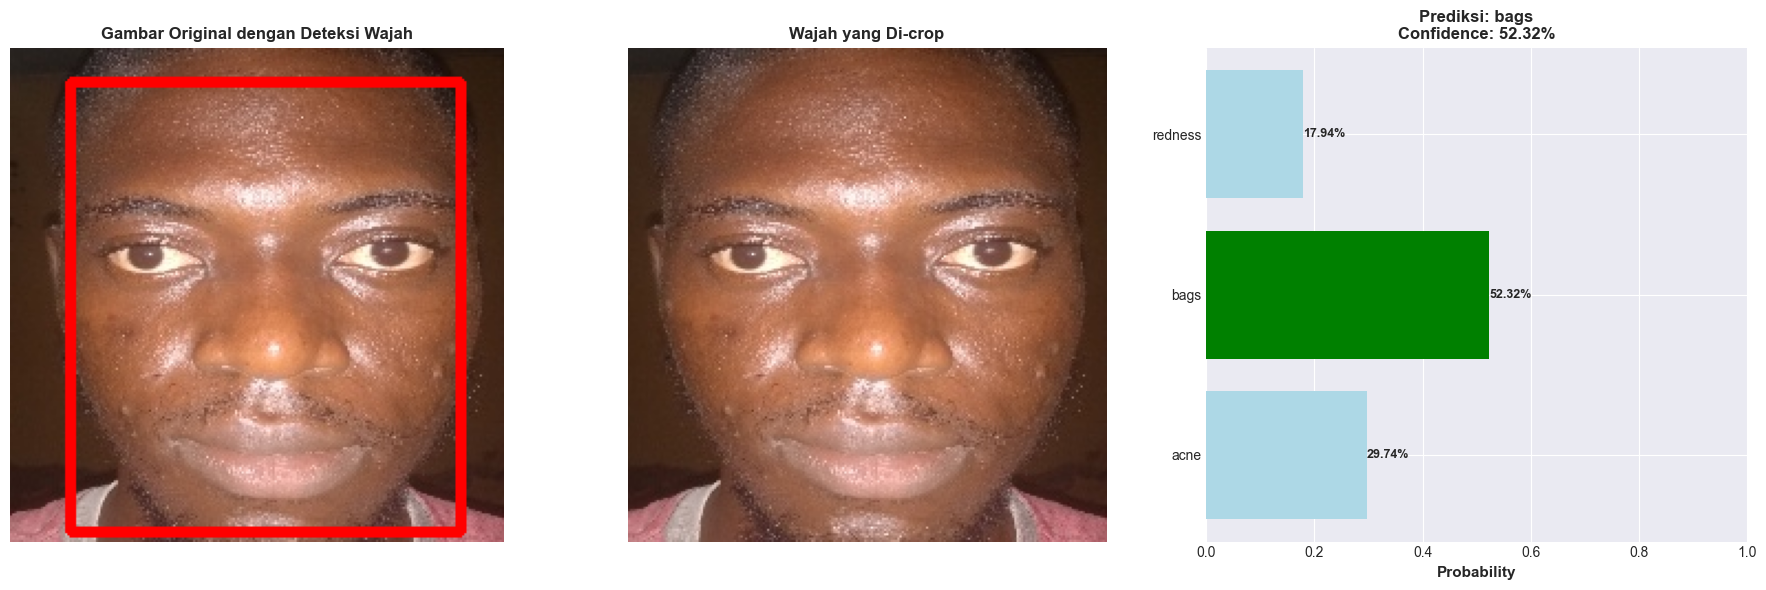


--- Sample 2 ---
True Label: bags
Predicted: bags (Confidence: 43.04%) ✅ Benar

--- Sample 4 ---
True Label: redness
Predicted: bags (Confidence: 36.17%) ❌ Salah



In [39]:
# Test prediksi pada beberapa sample dari test set
if faces is not None and len(faces) > 0:
    print("\n🔮 TESTING PREDICTION PIPELINE")
    print("="*60)
    
    # Pilih random samples dari test set
    n_samples = min(3, len(X_test))
    sample_indices = random.sample(range(len(X_test)), n_samples)
    
    for idx in sample_indices:
        print(f"\n--- Sample {idx+1} ---")
        
        # Untuk demonstrasi, kita perlu save gambar test terlebih dahulu
        # karena fungsi predict_skin_disease memerlukan path gambar
        test_img_path = os.path.join(OUTPUT_DIR, f'test_sample_{idx}.jpg')
        test_img = (X_test[idx] * 255).astype(np.uint8)
        cv2.imwrite(test_img_path, cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))
        
        true_label = class_names[y_test[idx]]
        print(f"True Label: {true_label}")
        
        # Prediksi (tanpa visualisasi untuk batch)
        face_batch = np.expand_dims(X_test[idx], axis=0)
        pred = model.predict(face_batch, verbose=0)[0]
        pred_class_idx = np.argmax(pred)
        pred_class = class_names[pred_class_idx]
        confidence = pred[pred_class_idx]
        
        status = "✅ Benar" if pred_class == true_label else "❌ Salah"
        print(f"Predicted: {pred_class} (Confidence: {confidence:.2%}) {status}")
        
        # Visualisasi untuk sample pertama
        if idx == sample_indices[0]:
            print("\n📊 Visualisasi detail untuk sample pertama:")
            # Prediksi dengan visualisasi
            result = predict_skin_disease(test_img_path, model, class_names, visualize=True)
    
    print("\n" + "="*60)

### Prediksi pada Gambar Baru (Upload)

In [40]:
# Prediksi pada gambar baru
# Uncomment dan sesuaikan path untuk melakukan prediksi pada gambar baru

# NEW_IMAGE_PATH = './path_to_your_new_image.jpg'
# 
# if os.path.exists(NEW_IMAGE_PATH) and faces is not None:
#     print("🔮 Melakukan prediksi pada gambar baru...\n")
#     result = predict_skin_disease(NEW_IMAGE_PATH, model, class_names, visualize=True)
#     
#     if result['success']:
#         print("\n📊 HASIL PREDIKSI:")
#         print(f"  Penyakit: {result['predicted_class']}")
#         print(f"  Confidence: {result['confidence']:.2%}")
#         print(f"  Face Detection Confidence: {result['detection_confidence']:.2%}")
#         print("\n  Probabilitas semua kelas:")
#         for class_name, prob in sorted(result['all_probabilities'].items(), 
#                                        key=lambda x: x[1], reverse=True):
#             print(f"    {class_name}: {prob:.2%}")
#     else:
#         print("❌ Prediksi gagal. Pastikan gambar mengandung wajah yang jelas.")
# else:
#     print("⚠️ Gambar tidak ditemukan atau model belum di-training.")
#     print("   Upload gambar dan set NEW_IMAGE_PATH untuk melakukan prediksi.")

## 💾 9. Save & Load Model

Menyimpan dan memuat model untuk penggunaan di masa depan.

In [41]:
# Save model
if faces is not None and len(faces) > 0:
    # Model sudah otomatis disimpan oleh ModelCheckpoint callback
    # Tapi kita bisa save manual juga
    final_model_path = os.path.join(OUTPUT_DIR, 'skin_disease_final_model.h5')
    model.save(final_model_path)
    print(f"✅ Model disimpan di: {final_model_path}")
    
    # Save class names
    import json
    class_names_path = os.path.join(OUTPUT_DIR, 'class_names.json')
    with open(class_names_path, 'w') as f:
        json.dump(class_names, f)
    print(f"✅ Class names disimpan di: {class_names_path}")
    
    # Save training history
    history_path = os.path.join(OUTPUT_DIR, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)
    print(f"✅ Training history disimpan di: {history_path}")

✅ Model disimpan di: ./output\skin_disease_final_model.h5
✅ Class names disimpan di: ./output\class_names.json
✅ Training history disimpan di: ./output\training_history.json


In [42]:
# Load model (untuk penggunaan di masa depan)
def load_trained_model(model_path, class_names_path):
    """
    Load model dan class names yang sudah di-training.
    """
    import json
    
    # Load model
    loaded_model = load_model(model_path)
    print(f"✅ Model berhasil dimuat dari: {model_path}")
    
    # Load class names
    with open(class_names_path, 'r') as f:
        loaded_class_names = json.load(f)
    print(f"✅ Class names berhasil dimuat: {loaded_class_names}")
    
    return loaded_model, loaded_class_names

# Contoh penggunaan:
# loaded_model, loaded_class_names = load_trained_model(
#     './output/skin_disease_final_model.h5',
#     './output/class_names.json'
# )
# result = predict_skin_disease('path_to_image.jpg', loaded_model, loaded_class_names)

## 📝 10. Summary dan Kesimpulan

Ringkasan hasil dan panduan penggunaan.

In [43]:
if faces is not None and len(faces) > 0:
    print("\n" + "="*70)
    print("📊 RINGKASAN PROYEK")
    print("="*70)
    print(f"\n🎯 Tujuan: Deteksi Wajah + Klasifikasi Penyakit Kulit")
    print(f"\n📂 Dataset:")
    print(f"   - Total samples: {len(faces)}")
    print(f"   - Jumlah kelas: {len(class_names)}")
    print(f"   - Kelas: {', '.join(class_names)}")
    print(f"   - Training: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")
    
    print(f"\n🏗️ Arsitektur Model:")
    print(f"   - Base: {'MobileNetV2 (Transfer Learning)' if USE_TRANSFER_LEARNING else 'Custom CNN'}")
    print(f"   - Input size: {IMG_SIZE}")
    print(f"   - Total parameters: {model.count_params():,}")
    
    print(f"\n📈 Performa Model:")
    print(f"   - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   - Test Precision: {test_precision:.4f}")
    print(f"   - Test Recall: {test_recall:.4f}")
    print(f"   - Test F1-Score: {f1:.4f}")
    
    print(f"\n💾 Output Files:")
    print(f"   - Model: {MODEL_SAVE_PATH}")
    print(f"   - Class names: output/class_names.json")
    print(f"   - Training history: output/training_history.json")
    print(f"   - Visualizations: output/*.png")
    print(f"   - Detected faces: {FACES_OUTPUT_DIR}")
    
    print(f"\n🔮 Cara Menggunakan Model untuk Prediksi:")
    print(f"   1. Load model: loaded_model, class_names = load_trained_model(...)")
    print(f"   2. Prediksi: result = predict_skin_disease(image_path, model, class_names)")
    print(f"   3. Hasil akan berisi: predicted_class, confidence, all_probabilities")
    
    print(f"\n✅ PROYEK SELESAI!")
    print("="*70 + "\n")
else:
    print("\n" + "="*70)
    print("⚠️ PROYEK BELUM LENGKAP")
    print("="*70)
    print("\nDataset tidak ditemukan atau tidak valid.")
    print("\n📝 Langkah selanjutnya:")
    print("1. Siapkan dataset dengan struktur folder yang benar")
    print("2. Update DATASET_PATH pada cell konfigurasi")
    print("3. Jalankan ulang notebook dari awal")
    print("\n💡 Tips:")
    print("- Pastikan setiap gambar memiliki wajah yang jelas")
    print("- Gunakan minimal 50-100 gambar per kelas untuk hasil terbaik")
    print("- Dataset dapat diunduh dari Kaggle, Dermnet, atau ISIC Archive")
    print("="*70 + "\n")


📊 RINGKASAN PROYEK

🎯 Tujuan: Deteksi Wajah + Klasifikasi Penyakit Kulit

📂 Dataset:
   - Total samples: 30
   - Jumlah kelas: 3
   - Kelas: acne, bags, redness
   - Training: 20 | Validation: 6 | Test: 4

🏗️ Arsitektur Model:
   - Base: MobileNetV2 (Transfer Learning)
   - Input size: (224, 224)
   - Total parameters: 3,086,659

📈 Performa Model:
   - Test Accuracy: 0.5000 (50.00%)
   - Test Precision: 0.0000
   - Test Recall: 0.0000
   - Test F1-Score: 0.4583

💾 Output Files:
   - Model: ./output\skin_disease_model.h5
   - Class names: output/class_names.json
   - Training history: output/training_history.json
   - Visualizations: output/*.png
   - Detected faces: ./output\detected_faces

🔮 Cara Menggunakan Model untuk Prediksi:
   1. Load model: loaded_model, class_names = load_trained_model(...)
   2. Prediksi: result = predict_skin_disease(image_path, model, class_names)
   3. Hasil akan berisi: predicted_class, confidence, all_probabilities

✅ PROYEK SELESAI!



---

## 🎓 Panduan dan Tips

### Struktur Dataset yang Disarankan:
```
skin_disease_dataset/
├── acne/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── eczema/
│   ├── image1.jpg
│   └── ...
├── melasma/
│   └── ...
└── healthy/
    └── ...
```

### Tips untuk Hasil Terbaik:

1. **Dataset Quality**:
   - Gunakan gambar dengan wajah yang jelas dan tidak terhalang
   - Minimal 50-100 gambar per kelas
   - Balanced dataset (jumlah sampel setiap kelas seimbang)
   - Variasi pencahayaan, angle, dan kondisi kulit

2. **Hyperparameter Tuning**:
   - Adjust LEARNING_RATE jika training terlalu lambat/cepat
   - Increase EPOCHS jika model belum converge
   - Modify BATCH_SIZE sesuai memory GPU

3. **Model Architecture**:
   - Transfer Learning (MobileNetV2) lebih cepat dan akurat untuk dataset kecil
   - Custom CNN lebih fleksibel tapi memerlukan data lebih banyak
   - Fine-tuning: unfreeze beberapa layer terakhir base model untuk performa lebih baik

4. **Data Augmentation**:
   - Sudah diaktifkan secara default
   - Adjust parameter jika diperlukan (rotation, zoom, flip, dll)

5. **Deployment**:
   - Save model dalam format .h5 atau SavedModel untuk production
   - Gunakan TensorFlow Lite untuk mobile deployment
   - Implement REST API menggunakan Flask/FastAPI

### Resources:

- **Dataset Publik**:
  - [DermNet](https://dermnet.com/)
  - [HAM10000 Dataset](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)
  - [ISIC Archive](https://www.isic-archive.com/)

- **Documentation**:
  - [TensorFlow](https://www.tensorflow.org/)
  - [Keras Applications](https://keras.io/api/applications/)
  - [MTCNN](https://github.com/ipazc/mtcnn)

---

## 📧 Contact & Support

Jika ada pertanyaan atau issues, silakan buka issue di GitHub repository atau hubungi tim development.

**Happy Deep Learning! 🚀**